In [1]:
from data import df_columns, data

In [2]:
import matplotlib.pyplot as plt

def create_bar_chart(x, y, xlabel, ylabel, title="", ylim_above=10, text_space_above_rect=2, do_show=True, ylim=None):
    h = plt.bar(x, y)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.ylim(0, max(y) + ylim_above)
    
    if ylim != None:
        plt.ylim(0, ylim)
    
    plt.title(title)
    
    for i in range(len(x)):
        year_value, count = x[i], y[i]
        plt.text(year_value, count+text_space_above_rect, str(count), ha='center')

    if do_show:
        plt.show()
    

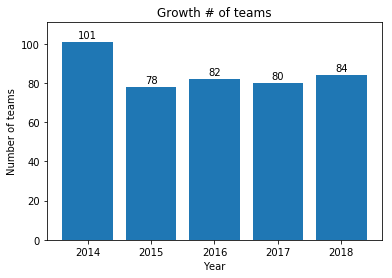

In [3]:
years = list(data.keys())
number_of_teams = [len(value) for key, value in data.items()]
create_bar_chart(years, number_of_teams, "Year", "Number of teams", "Growth # of teams")

In [4]:
print("How each row looks like?")
print(data[2017][0])
print(data[2017][30])
# team_ranking, university_name_team_name, solved, penalty, dont_know, submissions...

How each row looks like?
[1, 'Sharif University of Technology: Cliché\n', 9, 1206, 77, ['1/4', 'yes'], ['1/9', 'yes'], ['1/--', 'no'], ['1/171', 'yes'], ['2/27', 'yes first'], 0, ['1/241', 'yes'], ['1/37', 'yes first'], ['2/261', 'yes'], ['3/229', 'yes'], ['3/107', 'yes first'], ['16/9', '']]
[15, 'Kharazmi University: Bits Please.\n', 3, 385, 35, ['1/3', 'yes'], ['2/24', 'yes'], 0, ['1/--', 'no'], ['6/--', 'no'], 0, 0, ['4/278', 'yes'], 0, 0, 0, ['14/3', '']]


In [5]:
def get_attempts(s):
    return int(s.split('/')[0])

def get_accept_time(s):
    accept_time = s.split('/')[1]
    if accept_time.isdigit():
        return int(accept_time)
    else:
        return 0

def get_name(s):
    s = s.strip()
    point_idx = s.strip().find(':')
    return s[point_idx+2:].strip()

def get_university(s):
    s = s.strip()
    point_idx = s.strip().find(':')
    return s[:point_idx].strip()
    
class Submission:
    def __init__(self, sub):
        if sub == 0:
            self.accepted = False
            self.attempts = 0
            self.accept_time = 0
        else:
            self.attempts = get_attempts(sub[0])
            self.accept_time = get_accept_time(sub[0])
            self.accepted = sub[1] != 'no' and self.attempts > 0 and self.accept_time > 0
            
    def get_accept_time(self):
        return self.accept_time
    
    def get_attempts(self):
        return self.attempts
    
    def get_accepted(self):
        return self.accepted
            
    def __str__(self):
        return "Attempts:{}, Accepted:{}, Accept Time:{}".format(self.attempts, self.accepted, self.accept_time)
    
    def __repr__(self):
        return self.__str__()
    
class Team:
    def __init__(self, row=None):
        if row != None:
            self.ranking = row[0]
            self.name = get_name(row[1])
            self.university = get_university(row[1])
            self.solved = row[2]
            self.penalty = row[3]
            self.submissions = [Submission(x) for x in row[5:-1]]        
        else:
            self.ranking = -1
            self.name = ""
            self.university = ""
            self.submissions = []
            self.solved = 0
            self.penalty = 0
        
    def __hash__(self):
        return hash( (self.university, self.name) )
        
    def __eq__(self, other):
        return self.name == other.name and self.university == other.university
        
    def __str__(self):
        #return self.name + " -> " + str(self.submissions)
        return "{} - {}".format(self.university, self.name)
    
    def __repr__(self):
        return self.__str__()
    
    def __lt__(self, other):
        return self.solved > other.solved or \
            (self.solved == other.solved and self.penalty < other.penalty) or \
            (self.solved == other.solved and self.penalty == other.penalty and self.name < other.name)
    
    def add_solved(self, sub):
        self.solved += 1
        self.penalty += sub.get_accept_time() + (sub.attempts-1) * 20
    
    def set_name(self, name):
        self.name = name
        
    def get_name(self):
        return self.name
        
    def set_university(self, university):
        self.university = university
    
    def get_university(self):
        return self.university
    
    def get_solved(self):
        return self.solved
    
    def get_penalty(self):
        return self.penalty
    
    def get_submissions(self):
        return self.submissions


In [6]:
s1 = Submission(["1/8", 'yes'])
s2 = Submission(["10/--", 'no'])
print(s1)
print(s2)

Attempts:1, Accepted:True, Accept Time:8
Attempts:10, Accepted:False, Accept Time:0


In [7]:
t1 = Team([15, 'Kharazmi University: Bits Please.\n', 3, 385, 35, ['1/3', 'yes'], ['2/24', 'yes'], 0, ['1/--', 'no'], ['6/--', 'no'], 0, 0, ['4/278', 'yes'], 0, 0, 0, ['14/3', '']])
print(t1)

Kharazmi University - Bits Please.


In [8]:
import pandas as pd
from functools import reduce

class Contest:
    def __init__(self, year, teams):
        self.year = year
        self.teams = [Team(t) for t in teams]
    
    def __str__(self):
        return str(self.year)
    
    def get_unique_university_names(self):
        return {t.university for t in self.teams}
    
    def get_year(self):
        return self.year
    
    def get_teams(self):
        return self.teams
    
    def update_university_names(self, university_name_handler):
        for t in self.teams:
            t.set_university(university_name_handler(t.get_university()))
    
    def __repr__(self):
        return str(self.year) + " -> " + str([str(t) for t in self.teams]) + "\n"
    
    def get_df(self):
        df = pd.DataFrame(columns=df_columns)
        team_ranking = 1
        for t in self.teams:
            team_data = {'year':[self.year], 'ranking': [team_ranking], 'name': [t.get_name()], 'university': [t.get_university()], 'solved': [t.get_solved()], 
                        'penalty': [t.get_penalty()]}
            problem = 'a'
            
            for s in t.get_submissions():
                team_data["p{}_time".format(problem)] = [s.get_accept_time()]
                problem = chr(ord(problem) + 1)
                
            df = df.append(pd.DataFrame(data=team_data, columns=df_columns), ignore_index=True)            
            team_ranking += 1
            
#         print(df.head())
        
        return df
    
    
    def add_to_ranking(self, sub, team):
        found = False
        for t in self.ranking:
            if t == team:
                t.add_solved(sub)
                found = True
        
        if not found:
#             print("Hey", team.get_name())
            t = Team()
            t.set_name(team.get_name())
            t.set_university(team.get_university())
            t.add_solved(sub)
            self.ranking.append(t)
            
    
    def get_ranking_team(self, place):
        return self.ranking[0]
    
    
    def calculate_teams_with_rank(self, place):
        all_subs = reduce(list.__add__, [ [(s, t) for s in t.get_submissions()] for t in self.teams])
        all_subs = [(sub, team) for sub, team in all_subs if sub.accepted]        
        all_subs = sorted(all_subs, key=(lambda x: x[0].get_accept_time()))
        
        self.ranking = []
        result = dict()
        prev_accept_time = 0
        
        idx = 0
        while idx < len(all_subs):

            sub, team = all_subs[idx]
            current_accept_time = sub.get_accept_time()

            for h in self.ranking:
                if h.get_solved() == self.ranking[0].get_solved() and h.get_penalty() == self.ranking[0].get_penalty():
                    if h in result:
                        result[h] += current_accept_time - prev_accept_time
                    else:
                        result[h] = current_accept_time - prev_accept_time
            
            self.add_to_ranking(sub, team)

            idx += 1
            while idx < len(all_subs) and current_accept_time == all_subs[idx][0].get_accept_time():
                sub, team = all_subs[idx]
                self.add_to_ranking(sub, team)
                idx += 1
            
            self.ranking = sorted(self.ranking)
            prev_accept_time = current_accept_time

        for h in self.ranking:
            if h.get_solved() == self.ranking[0].get_solved() and h.get_penalty() == self.ranking[0].get_penalty():
                if h in result:
                    result[h] += 300 - prev_accept_time
                else:
                    result[h] = 300 - prev_accept_time

#             print("##" * 30)
#             print("now", idx)
#             for t in self.ranking[0:5]:
#                 print("{} -> solved={}, penalty={}".format(t.get_name(), t.get_solved(), t.get_penalty()))
            
        
        df = pd.DataFrame(columns=['year', 'university', 'name', 'time_rank_1'])
    
#         print("##" * 30)
        sorted_result = (sorted([(team, time) for team, time in result.items()], key=lambda x: -x[1]) )
        for row in sorted_result:
            df = df.append(pd.DataFrame({'year':[self.year], 'university':[row[0].get_university()], 'name':[row[0].get_name()], 'time_rank_1':[row[1]]}))

#         print(df)
        return df
            
        


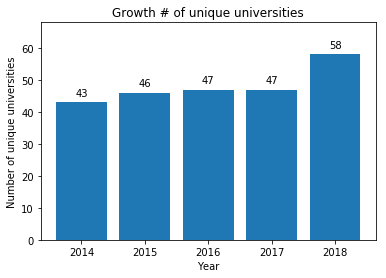

In [9]:
contests = [Contest(year=key, teams=value) for key, value in data.items()]
years = [c.get_year() for c in contests]
nunique_universities = [len(c.get_unique_university_names()) for c in contests]
create_bar_chart(years, nunique_universities, "Year", "Number of unique universities", "Growth # of unique universities")

In [10]:
# printing all university names, for further exploration and removing duplicate names

all_universities = []
for c in contests:
    all_universities.extend( list(c.get_unique_university_names()) )
all_universities = set(all_universities)

#for t in sorted(all_universities):
#    print("['{}'],".format(t))


In [11]:
from universities import universities
print("Number of unique universities over years : {}".format(len(universities)))

Number of unique universities over years : 84


In [12]:
# updating all university names
from universities import get_university_name
for c in contests:    
    c.update_university_names(get_university_name)
    print(sorted(c.get_unique_university_names())[:5])


['Alzahra University', 'Amirkabir University of Technology', 'Azad U of Tehran Center', 'Azad U of Tehran South', 'Azarbijan Shahid Madani U']
['Alzahra University', 'Amirkabir University of Technology', 'Birjand University', 'Bu-Ali Sina University', 'Ferdowsi University of Mashhad']
['Alzahra University', 'Amirkabir University of Technology', 'Birjand University', 'Bu-Ali Sina University', 'Fasa University']
['Alzahra University', 'Amirkabir University of Technology', 'Ardabil Technical and Vocational University', 'Bonab Faculty of Engineering', 'Bu-Ali Sina University']
['Ale-Taha Institute Of Higher Education', 'Alzahra University', 'Amirkabir University of Technology', 'Azad University of Lahijan', 'Babol University of Technology']


In [13]:
# creating a csv from all the data to be used by DataFrame from now on
import pandas as pd
df = pd.DataFrame(columns=df_columns)
for c in contests:
    df = df.append(c.get_df(), ignore_index=True)
df.to_csv("standings_data.csv", index=False)

In [14]:
for col in set(df.columns) - set(['name', 'university']):
    df[col] = pd.to_numeric(df[col])

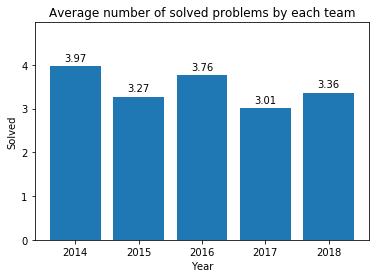

In [15]:
grouped = df.groupby('year').mean()['solved']
years = list(grouped.index)
avg_solved = [round(x, 2) for x in list(grouped)]
create_bar_chart(years, avg_solved, "Year", "Solved", "Average number of solved problems by each team", ylim_above=1, text_space_above_rect=0.12)

In [16]:
grouped = df.groupby(['year', 'university']).mean()['solved']
grouped = grouped.unstack(level=-1)
grouped = grouped.round(2)
grouped.columns = sorted(grouped.columns)
grouped.to_csv('average_number_of_solved_by_university.csv')

# for year in df['year'].unique():
#     print("Year = {}".format(year))
#     grouped = df[df.year == year].groupby('university').mean()['solved']
#     print(grouped.sort_values(ascending=False)[0:10])
#     print("--" * 35)

In [17]:
# how many problems medalists have solved at each hour of contest?

for hour in range(1, 6):
    df['solved_hour_{}'.format(hour)] = sum([ ((hour-1) * 60 < df["p{}_time".format(chr(ch_int))]) & (df["p{}_time".format(chr(ch_int))] <= hour * 60) for ch_int in range(ord('a'), ord('n'))])

df[df.ranking <= 12][['year', 'ranking', 'name', 'university', 'solved', 'solved_hour_1', 'solved_hour_2', 'solved_hour_3', 'solved_hour_4', 'solved_hour_5']]

,year,ranking,name,university,solved,solved_hour_1,solved_hour_2,solved_hour_3,solved_hour_4,solved_hour_5
0,2014,1,Saboon,Sharif University of Technology,10,4,3,2,0,1
1,2014,2,We miss iliad,Sharif University of Technology,9,4,1,2,2,0
2,2014,3,Shire Aab,Sharif University of Technology,9,5,0,2,1,1
3,2014,4,Carrots in Black,Sharif University of Technology,8,3,3,1,1,0
4,2014,5,iliad,Sharif University of Technology,8,5,1,0,2,0
5,2014,6,Odd Factory,University of Tehran,8,4,1,1,1,1
6,2014,7,Dark Side of Trianguli,Shahid Beheshti University,7,3,1,1,2,0
7,2014,8,Triple Narengies :),University of Tehran,7,2,1,2,1,1
8,2014,9,Naddaaf,Sharif University of Technology,7,3,0,1,1,2
9,2014,10,70856775327334,Islamic Azad University of Mashhad,6,4,1,1,0,0


In [18]:
grouped = df.groupby('year').sum()
grouped['total_solved'] = (grouped['solved_hour_1'] + grouped['solved_hour_2'] + grouped['solved_hour_3'] + grouped['solved_hour_4'] + grouped['solved_hour_5'])

for hour in range(1, 6):
    col = 'solved_hour_{}'.format(hour)
    grouped[col] = round(grouped[col] / grouped['total_solved'] * 100, 0).astype(int)

solved_columns = ['solved_hour_1', 'solved_hour_2', 'solved_hour_3', 'solved_hour_4', 'solved_hour_5']
grouped[solved_columns]

,solved_hour_1,solved_hour_2,solved_hour_3,solved_hour_4,solved_hour_5
year,,,,,
2014,51,17,15,11,6
2015,51,17,14,12,6
2016,61,15,9,8,6
2017,68,12,7,6,7
2018,63,12,12,7,5


In [19]:
grouped = grouped[solved_columns]
grouped = grouped.transpose()

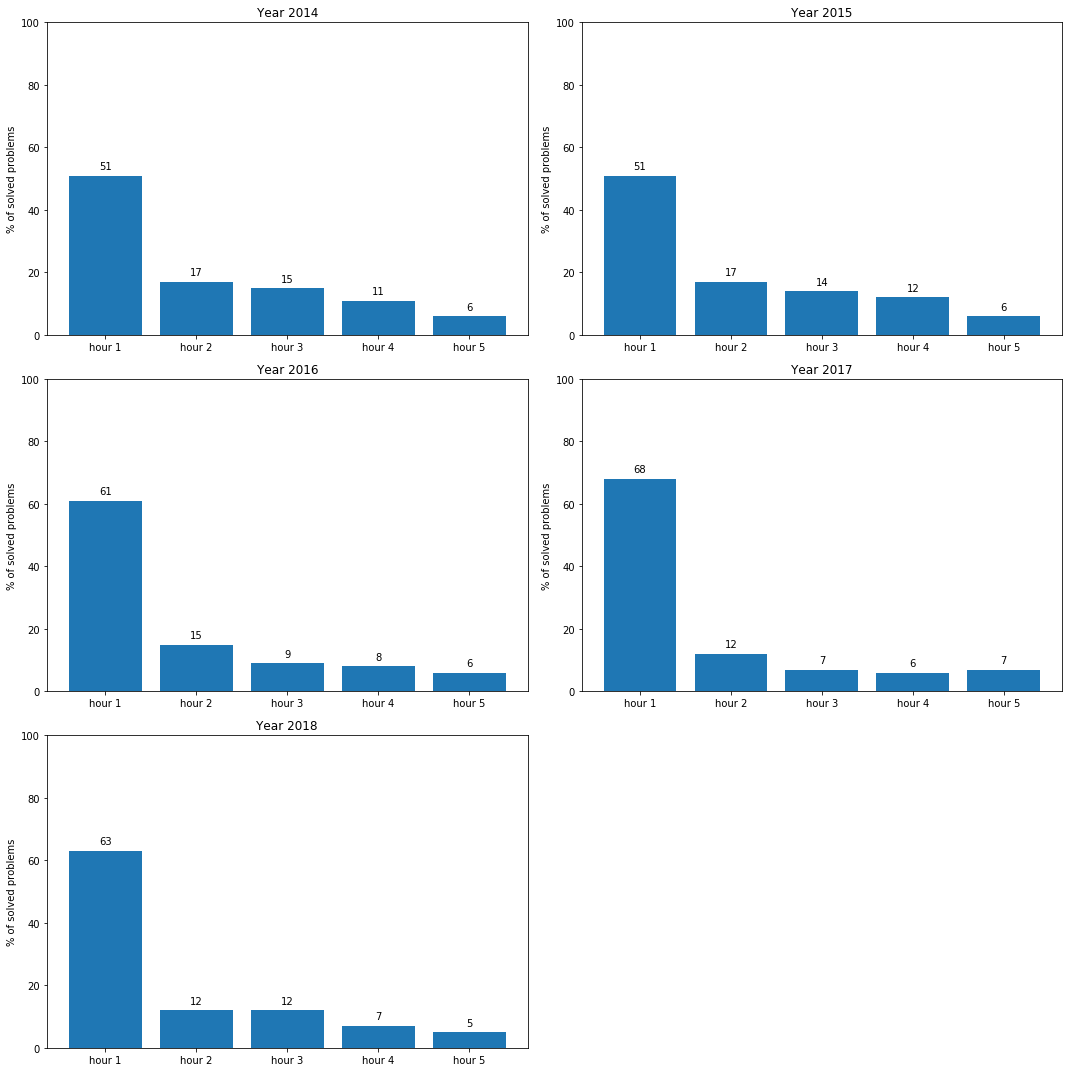

In [20]:
# distribution of accepts in each hour of the contest

fig, axes = plt.subplots(3, 2, figsize=(15,15))

plot_number = 1
for year in grouped.columns:
    plt.subplot(3,2,plot_number)
    plot_number += 1
    create_bar_chart(['hour 1', 'hour 2', 'hour 3', 'hour 4', 'hour 5'], list(grouped[year]), "", "% of solved problems", title="Year {}".format(year), ylim=100, do_show=False)

fig.delaxes(axes[2][1])
plt.tight_layout()
plt.savefig("percent_of_solved_problems.jpg")
plt.show()

In [21]:
time_first_df = pd.DataFrame(columns=['year', 'university', 'name', 'time_rank_1'])
for c in contests:
   time_first_df = time_first_df.append(c.calculate_teams_with_rank(1))
time_first_df.to_csv("time_at_rank_1.csv", index=False)

time_first_df

,year,university,name,time_rank_1
0,2014,Sharif University of Technology,Saboon,237
0,2014,Sharif University of Technology,iliad,61
0,2014,Shahid Beheshti University,Dark Side of Trianguli,7
0,2014,Sharif University of Technology,We miss iliad,7
0,2015,Sharif University of Technology,CrockPot,110
0,2015,Sharif University of Technology,Iliad is coming,105
0,2015,Shahid Beheshti University,Dog ate,81
0,2015,Shiraz University,AYA?,6
0,2015,University of Tehran,Narengies Factory :),6
0,2016,Sharif University of Technology,CrockPot,174


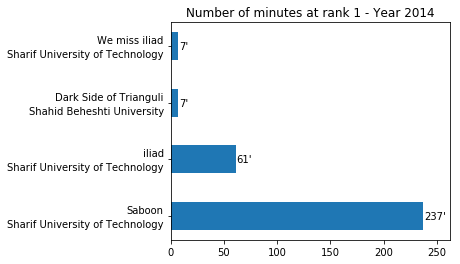

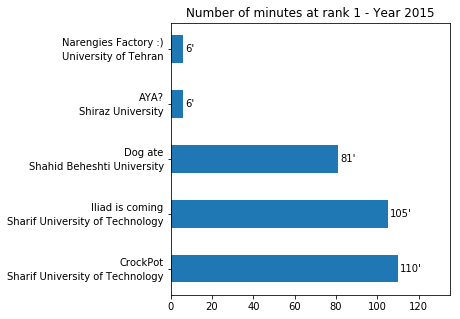

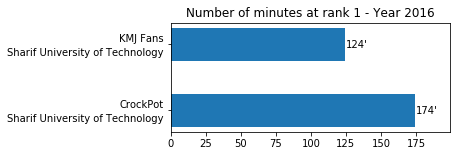

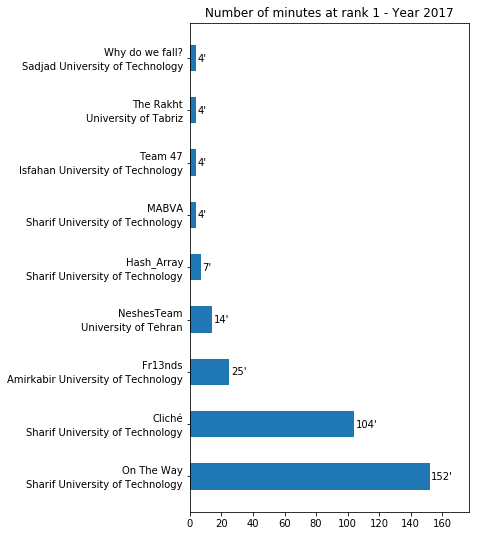

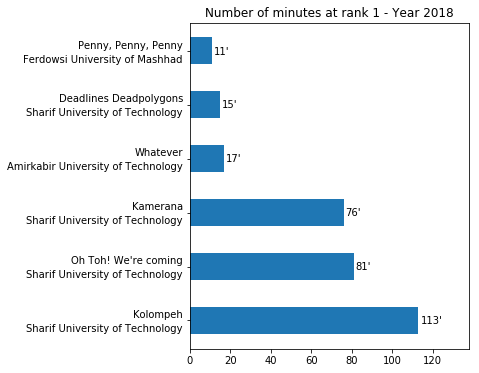

In [22]:
import numpy as np

for year in time_first_df['year'].unique():
    times_first = list(time_first_df[time_first_df.year == year]['time_rank_1'])
    team_names = list(time_first_df[time_first_df.year == year]['name'])
    university_names = list(time_first_df[time_first_df.year == year]['university'])
    y_pos = np.arange(0, 8*len(times_first), 8)

    fig, ax = plt.subplots(figsize=(5,len(times_first)))

    ax.barh(y_pos, times_first, align='center', height=4)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(["{}\n{}".format(team_names[i], university_names[i]) for i in range(len(times_first))], linespacing=1.5)
    ax.set_xlim(0, max(times_first) + 25)

    plt.title( "Number of minutes at rank 1 - Year {}".format(year) )
    
    for i in range(len(times_first)):
        x, y = times_first[i], y_pos[i]
        ax.text(x+1, y, "{}'".format(x), va='center')

    plt.savefig("minutes_rank_one_{}.jpg".format(year))
    plt.show()

In [23]:
def calculate_top_universities_combination(top_count=4):
    rank_data = {}
    rank_df = pd.DataFrame(columns = [i for i in range(1, top_count+1)])

    for c in contests:
        universities = []
        for t in c.get_teams():
            if t.get_university() not in universities:
                universities.append(t.get_university())
                if len(universities) == top_count:
                    break

        university_rank = 1
        for u in universities:
            if u in rank_df.index:
                rank_df[university_rank][u] += 1
            else:
                team_data = {i:0 for i in range(1, top_count+1)}
                team_data[university_rank] += 1
                temp_df = pd.DataFrame(team_data, columns=[i for i in range(1,top_count+1)], index=[u])
                rank_df = rank_df.append(temp_df)

            university_rank += 1
    
    return rank_df

calculate_top_universities_combination(2)

,1,2
Sharif University of Technology,5,0
University of Tehran,0,3
Shahid Beheshti University,0,1
Amirkabir University of Technology,0,1


In [24]:
calculate_top_universities_combination(4)

,1,2,3,4
Sharif University of Technology,5,0,0,0
University of Tehran,0,3,1,1
Shahid Beheshti University,0,1,3,0
Islamic Azad University of Mashhad,0,0,0,1
Ferdowsi University of Mashhad,0,0,1,1
Isfahan University of Technology,0,0,0,1
Amirkabir University of Technology,0,1,0,0
Shahid Bahonar University of Kerman,0,0,0,1


In [25]:
from utils import ProvinceHandler

def get_province_count(contest):
    data = dict()
    for t in contest.get_teams():
        prov = ProvinceHandler.get_province(t.get_university())
        if prov in data:
            data[prov] += 1
        else:
            data[prov] = 1
            
#     print( sorted( [(key, value) for key, value in data.items()], key=lambda x: -x[1] ) )
    return data


['Alborz', 'Ardabil', 'Azerbaijan, East', 'Azerbaijan, West', 'Bushehr', 'Chahar Mahaal and Bakhtiari', 'Fars', 'Gilan', 'Golestan', 'Hamadan', 'Hormozgan', 'Ilam', 'Isfahan', 'Kerman', 'Kermanshah', 'Khorasan, North', 'Khorasan, Razavi', 'Khorasan, South', 'Khuzestan', 'Kohgiluyeh and Boyer-Ahmad', 'Kurdistan', 'Lorestan', 'Markazi', 'Mazandaran', 'Qazvin', 'Qom', 'Semnan', 'Sistan and Baluchestan', 'Tehran', 'Yazd', 'Zanjan']


In [26]:
year_columns = [c.get_year() for c in contests]

province_df = pd.DataFrame(columns=year_columns, index=ProvinceHandler.get_all_provinces())

for c in contests:
    data = get_province_count(c)
    temp_df = pd.DataFrame(data=data.values(), index=data.keys(), columns=[c.get_year()])
    province_df[c.get_year()] = temp_df[c.get_year()]
    
province_df.sort_values(by=[2018], ascending=False, inplace=True)
province_df

,2014,2015,2016,2017,2018
Tehran,42.0,24.0,25.0,25.0,22.0
"Khorasan, Razavi",13.0,8.0,10.0,12.0,12.0
Isfahan,8.0,11.0,12.0,9.0,8.0
Hamadan,NaN,1.0,2.0,3.0,4.0
Kerman,5.0,4.0,4.0,4.0,4.0
Qom,NaN,1.0,1.0,3.0,4.0
Fars,8.0,6.0,6.0,3.0,4.0
"Azerbaijan, West",3.0,4.0,4.0,2.0,3.0
Qazvin,2.0,2.0,NaN,2.0,3.0
Golestan,NaN,NaN,1.0,2.0,2.0


In [56]:
solve_count_df = df.groupby('year')['solved'].value_counts()
solve_count_df = solve_count_df.unstack(level=-1)
solve_count_df.fillna(0, inplace=True)
solve_count_df = solve_count_df.transpose()

solve_count_df

year,2014,2015,2016,2017,2018
solved,,,,,
0,0.0,1.0,0.0,0.0,0.0
1,4.0,3.0,3.0,2.0,3.0
2,23.0,26.0,13.0,47.0,18.0
3,26.0,19.0,33.0,6.0,45.0
4,12.0,15.0,17.0,12.0,4.0
5,10.0,7.0,5.0,6.0,6.0
6,17.0,3.0,6.0,2.0,1.0
7,3.0,3.0,1.0,4.0,3.0
8,3.0,0.0,0.0,0.0,2.0


In [ ]:
import seaborn as sns
ax = sns.lineplot(data=solve_count_df, dashes=False)
ax.set(xlabel="# of solved problems", ylabel="# of teams")

In [27]:
# what should your ranking be before last hour to guarantee medal in ICPC WF? (statistically) (you must have some ranking, or you must solve certain number of problems to guarantee medal)